In [19]:
import pandas as pd
from typing import List, Tuple
import numpy as np
from collections import Counter

In [20]:
from keras.layers import Input, Dense, LSTM, Flatten, concatenate, Activation, RepeatVector, Permute
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
import numpy as np 
import spacy
nlp = spacy.load('en_core_web_sm', disable=["pos", "ner", "tagger"])

In [2]:
df=pd.read_csv('cleaned_data.csv') 
df.head()

,User_id,Product_id,Rating,Date,Review,Label,Review_cleaned,Review_no_stopwords,Review_Lemma
0,923,0,3,2014-12-08,the food at snack is a selection of popular gr...,-1,the food at snack is a selection of popular gr...,food snack selection popular greek dishes appe...,food snack selection popular greek dish appeti...
1,924,0,3,2013-05-16,this little place in soho is wonderful. i had ...,-1,this little place in soho is wonderful i had ...,little place soho wonderful lamb sandwich glas...,little place soho wonderful lamb sandwich glas...
2,925,0,4,2013-07-01,ordered lunch for 15 from snack last friday. ã...,-1,ordered lunch for NUMBER from snack last fri...,ordered lunch NUMBER snack last friday ãâ tim...,order lunch NUMBER snack last friday ãâ time ...
3,926,0,4,2011-07-28,this is a beautiful quaint little restaurant o...,-1,this is a beautiful quaint little restaurant o...,beautiful quaint little restaurant pretty stre...,beautiful quaint little restaurant pretty stre...
4,927,0,4,2010-11-01,snack is great place for a ãâ casual sit down...,-1,snack is great place for a ãâ casual sit down...,snack great place ãâ casual sit lunch especia...,snack great place ãâ casual sit lunch especia...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359052 entries, 0 to 359051
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User_id              359052 non-null  int64 
 1   Product_id           359052 non-null  int64 
 2   Rating               359052 non-null  int64 
 3   Date                 359052 non-null  object
 4   Review               359052 non-null  object
 5   Label                359052 non-null  int64 
 6   Review_cleaned       359052 non-null  object
 7   Review_no_stopwords  359001 non-null  object
 8   Review_Lemma         359001 non-null  object
dtypes: int64(4), object(5)
memory usage: 24.7+ MB


In [5]:
# df[df['Review_Lemma'].isna()]

In [4]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359001 entries, 0 to 359051
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User_id              359001 non-null  int64 
 1   Product_id           359001 non-null  int64 
 2   Rating               359001 non-null  int64 
 3   Date                 359001 non-null  object
 4   Review               359001 non-null  object
 5   Label                359001 non-null  int64 
 6   Review_cleaned       359001 non-null  object
 7   Review_no_stopwords  359001 non-null  object
 8   Review_Lemma         359001 non-null  object
dtypes: int64(4), object(5)
memory usage: 27.4+ MB


In [5]:
df['Product_id'].nunique()

923

In [6]:
df.Label.value_counts()

 1    322123
-1     36878
Name: Label, dtype: int64

In [7]:
df.Rating.value_counts()

5    141141
4    135236
3     47635
2     20771
1     14218
Name: Rating, dtype: int64

* **Rated 1,2,3: negative reviews**
* **Rated 4,5: positive reviews**

In [8]:
genuine=df[df['Label']==1].reset_index().drop(columns='index')
genuine.head()

,User_id,Product_id,Rating,Date,Review,Label,Review_cleaned,Review_no_stopwords,Review_Lemma
0,937,0,4,2014-10-15,"tiny little place, but very good food. pastits...",1,tiny little place but very good food pastits...,tiny little place good food pastitsio especial...,tiny little place good food pastitsio especial...
1,938,0,5,2014-10-10,i had the braised lamb sandwich and was one of...,1,i had the braised lamb sandwich and was one of...,braised lamb sandwich one best sandwiches life...,braise lamb sandwich one best sandwich life fa...
2,939,0,3,2014-10-03,this spot is close to my job so i decided to c...,1,this spot is close to my job so i decided to c...,spot close job decided check lunch prices woul...,spot close job decide check lunch price would ...
3,940,0,4,2014-09-16,"for lunch, my friend and i had: -lamb sandwich...",1,for lunch my friend and i had lamb sandwich...,lunch friend lamb sandwich juicy flavorful roa...,lunch friend lamb sandwich juicy flavorful roa...
4,941,0,5,2014-08-10,"needed a quick, healthy light ""lunch"" and this...",1,needed a quick healthy light lunch and this...,needed quick healthy light lunch place perfect...,need quick healthy light lunch place perfect n...


In [9]:
genuine['Tag']=np.where(genuine['Rating']>3, 1, 0)
genuine.head()

,User_id,Product_id,Rating,Date,Review,Label,Review_cleaned,Review_no_stopwords,Review_Lemma,Tag
0,937,0,4,2014-10-15,"tiny little place, but very good food. pastits...",1,tiny little place but very good food pastits...,tiny little place good food pastitsio especial...,tiny little place good food pastitsio especial...,1
1,938,0,5,2014-10-10,i had the braised lamb sandwich and was one of...,1,i had the braised lamb sandwich and was one of...,braised lamb sandwich one best sandwiches life...,braise lamb sandwich one best sandwich life fa...,1
2,939,0,3,2014-10-03,this spot is close to my job so i decided to c...,1,this spot is close to my job so i decided to c...,spot close job decided check lunch prices woul...,spot close job decide check lunch price would ...,0
3,940,0,4,2014-09-16,"for lunch, my friend and i had: -lamb sandwich...",1,for lunch my friend and i had lamb sandwich...,lunch friend lamb sandwich juicy flavorful roa...,lunch friend lamb sandwich juicy flavorful roa...,1
4,941,0,5,2014-08-10,"needed a quick, healthy light ""lunch"" and this...",1,needed a quick healthy light lunch and this...,needed quick healthy light lunch place perfect...,need quick healthy light lunch place perfect n...,1


In [10]:
genuine['Tag'].value_counts()

1    248625
0     73498
Name: Tag, dtype: int64

## Tokenize

### Set a Maximum Sequence Length

In [11]:
# pip install transformers

In [21]:
docs=genuine['Review_Lemma']

In [22]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(docs)

In [23]:
from typing import List
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

# get the max length in terms of token length
max_length = get_max_token_length_per_doc(docs)

In [67]:
max_length 

1321

In [103]:
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = max_length
# integer encode the documents
encoded_docs = integer_encode_documents(docs, tokenizer)
# this is a list of lists, the numbers represent the index position of that word.
# for instance, 33 means the 33rd word in the vocabulary
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [104]:
print(f"Encoded docs: {encoded_docs[:5]}")

print(f"Padded docs: {padded_docs[:5]}")

Encoded docs: [[334, 40, 5, 4, 6, 1, 231, 4], [979, 252, 84, 13, 31, 84, 459, 1, 18, 5, 88, 19, 3704, 137], [101, 265, 837, 203, 184, 119, 53, 22, 164, 1384, 1279, 505, 105, 119, 53, 55, 11, 27, 3, 1106, 1280, 284, 263, 73, 12, 43, 321, 103, 319, 33, 453, 73, 33, 2456, 333, 248, 992, 14, 1758, 200, 5059, 70, 86, 1287, 1016, 67, 576, 40, 375, 176, 262, 34, 273, 34, 73, 164, 445, 16, 517, 166, 2256, 576, 73, 273, 180, 1004, 331, 200, 576, 616, 50, 177, 1805, 34, 73, 174, 19, 88, 326, 23, 715, 1943, 334, 22, 8, 20, 18, 133, 226, 157, 73], [119, 37, 252, 84, 426, 269, 319, 764, 73, 48, 123, 131, 4, 64, 37, 171, 742, 43, 22, 1774, 34, 764, 139, 232, 516, 797, 1, 616, 1427, 33, 259, 5206, 37, 15, 8855, 5, 5, 57, 3, 29, 727, 4, 19, 203, 977], [142, 326, 775, 187, 119, 5, 100, 112, 14, 44, 3332, 590, 21, 18, 8985, 84, 28, 6, 60, 214, 308, 24]]
Padded docs: [[334  40   5 ...   0   0   0]
 [979 252  84 ...   0   0   0]
 [101 265 837 ...   0   0   0]
 [119  37 252 ...   0   0   0]
 [142 326 775 .

### Encode Labels

In [27]:
labels = genuine['Tag']

In [28]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = to_categorical(encoder.fit_transform(labels))

In [102]:
labels

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

## Perform Train/Test Split

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels,random_state=42, test_size=0.2,stratify=labels)

In [31]:
pd.DataFrame(y_test).value_counts()

0    1  
0.0  1.0    49725
1.0  0.0    14700
dtype: int64

In [32]:
pd.DataFrame(y_train).value_counts()

0    1  
0.0  1.0    198900
1.0  0.0     58798
dtype: int64

## Import Keras Toolkit

In [34]:
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense

In [35]:
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

In [36]:
import tensorflow
tensorflow.random.set_seed(42)

## Load in GloVe Vectors

In [39]:
from typing import Dict
def load_glove_vectors()-> Dict:
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


## Load in Embeddings

In [101]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

## Define in Model

In [165]:
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking
# define model
def make_binary_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

## Compile Model

In [166]:
model = make_lstm_classification_model()
model_rnn = make_binary_classification_rnn_model()
print(model)
print(model_rnn)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 1321, 100)         12232000  
_________________________________________________________________
masking_14 (Masking)         (None, 1321, 100)         0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_28 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 34        
Total params: 12,249,586
Trainable params: 17,586
Non-trainable params: 12,232,000
_________________________________________________________________
Model: "sequential_16"
_________________________________________________________________
Layer (type) 

## Fit the Model

In [167]:
# fit the model
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=3, verbose=1)

Epoch 1/3
7248/7248 [==============================] - 6013s 829ms/step - loss: 0.4007 - accuracy: 0.8243 - val_loss: 0.3082 - val_accuracy: 0.8711
Epoch 2/3
7248/7248 [==============================] - 31752s 4s/step - loss: 0.2992 - accuracy: 0.8757 - val_loss: 0.2933 - val_accuracy: 0.8785
Epoch 3/3
7248/7248 [==============================] - 13407s 2s/step - loss: 0.2817 - accuracy: 0.8834 - val_loss: 0.2835 - val_accuracy: 0.8819


In [168]:
# fit the rnn model
history2 = model_rnn.fit(X_train, y_train,validation_split = 0.1, epochs=3, verbose=1)

Epoch 1/3
7248/7248 [==============================] - 2756s 380ms/step - loss: 0.5236 - accuracy: 0.7706 - val_loss: 0.5291 - val_accuracy: 0.7692
Epoch 2/3
7248/7248 [==============================] - 2367s 327ms/step - loss: 0.5064 - accuracy: 0.7725 - val_loss: 0.5186 - val_accuracy: 0.7688
Epoch 3/3
7248/7248 [==============================] - 2382s 329ms/step - loss: 0.5066 - accuracy: 0.7745 - val_loss: 0.5189 - val_accuracy: 0.7680


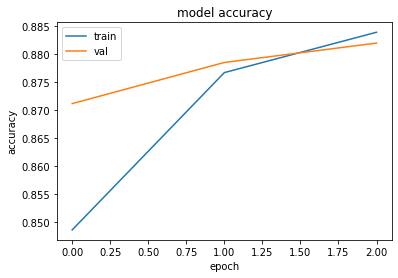

In [169]:
# draw model
import keras
from matplotlib import pyplot as plt

def plot_fit_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_fit_history(history)

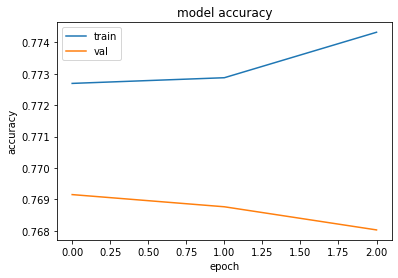

In [170]:
# draw model rnn
plot_fit_history(history2)

## Evaluate the Model

In [171]:
# baseline accuracy
genuine['Tag'].mean()

0.7718324987659994

In [172]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

2014/2014 [==============================] - 174s 87ms/step - loss: 0.2863 - accuracy: 0.8806
Accuracy: 88.060534


In [173]:
# evaluate the rnn model
loss, accuracy = model_rnn.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

2014/2014 [==============================] - 176s 88ms/step - loss: 0.5136 - accuracy: 0.7717
Accuracy: 77.168798


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
height = genuine['Review_Lemma'].apply(len)

(array([2.49412e+05, 5.76650e+04, 1.09720e+04, 2.73300e+03, 8.83000e+02,
        4.28000e+02, 2.60000e+01, 3.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.0000e+00, 5.6250e+02, 1.1240e+03, 1.6855e+03, 2.2470e+03,
        2.8085e+03, 3.3700e+03, 3.9315e+03, 4.4930e+03, 5.0545e+03,
        5.6160e+03]),
 <a list of 10 Patch objects>)

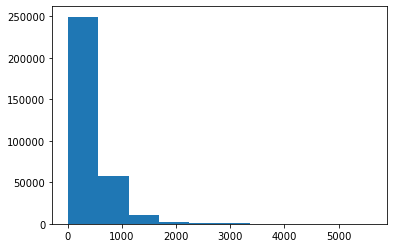

In [81]:
plt.hist(height, bins=10)

In [174]:
predictions = model.predict(X_test)

In [175]:
predictions

array([[0.23710972, 0.7628903 ],
       [0.27308726, 0.72691274],
       [0.03399411, 0.9660059 ],
       ...,
       [0.5366119 , 0.46338812],
       [0.07428753, 0.92571247],
       [0.08190072, 0.9180993 ]], dtype=float32)

In [183]:
from sklearn.metrics import confusion_matrix
y_pred = (predictions > 0.5)

matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [184]:
matrix

array([[ 9311,  5389],
       [ 2303, 47422]])

In [188]:
precision = 9311/(9311+5389)
precision

0.6334013605442177

In [189]:
recall = 9311/(9311+2303)
recall

0.801704838987429